<a href="https://colab.research.google.com/github/adunStudio/hanghae99_plusAI_2/blob/main/1%EC%A3%BC%EC%B0%A8/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [FEEDBACK] 맥 환경입니다. CUDA가 아닌 MPS 사용해도 될까요?

| **항목**          | **CUDA**                                  | **MPS (Metal Performance Shaders)**        |
|-------------------|------------------------------------------|-------------------------------------------|
| **제작사**       | NVIDIA                                   | Apple                                     |
| **호환 하드웨어** | NVIDIA GPU 전용                         | Apple Silicon (M1, M2), 일부 Intel Mac GPU |
| **플랫폼**       | Windows, Linux, macOS (NVIDIA GPU만)     | macOS 및 iOS                              |
| **프로그래밍 모델** | CUDA C/C++, Python, cuDNN 등 지원       | Metal API 기반, Python (PyTorch MPS)       |
| **프레임워크 호환성** | TensorFlow, PyTorch, MXNet, etc.         | PyTorch (MPS 백엔드)                      |
| **생태계**       | 매우 광범위, NVIDIA GPU 생태계에 집중    | Apple 생태계 내에 한정                    |
| **API 및 라이브러리** | CUDA Core, cuDNN, cuBLAS, TensorRT 등    | Metal Performance Shaders API             |

In [11]:
import torch
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}")

device = torch.device("mps")

MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? True


# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

# [MY CODE] Test data 준비하기 1/2


In [13]:
# 데이터셋 전처리:
# 1. PIL 이미지 또는 NumPy 배열 → PyTorch Tensor로 변환
# 2. 이미지를 Tensor로 변환 (픽셀 값을 [0, 1] 범위로 정규화)
transform = transforms.ToTensor()

# MNIST 학습 데이터셋 로드
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

# MNIST 테스트 데이터셋 로드
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


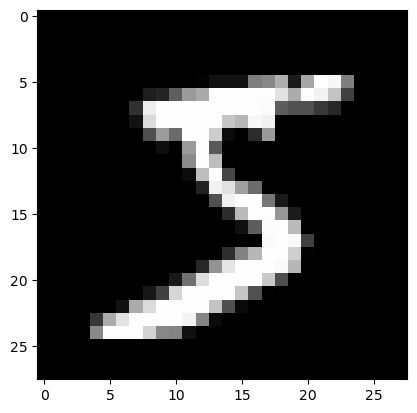

In [14]:
from matplotlib import pyplot as plt

print(len(train_set))
print(train_set[0][0].shape, train_set[0][1])
plt.imshow(train_set[0][0][0], cmap='gray')
# 60,000개의 이미지로 구성되어있다.
# [1, 28, 28]: 1채널(흑백), 28 x 28 크기 이미지

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

# [MY CODE] Test data 준비하기 2/2


In [15]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [17]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [18]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, num_dim, num_classes):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, num_dim)
    self.layer2 = nn.Linear(num_dim, num_dim)
    self.layer3 = nn.Linear(num_dim, num_classes)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024, 10)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

# [MY CODE] nn.CrossEntropyLoss 적용하기

In [19]:
from torch.optim import SGD

lr = 0.001
model = model.to(device)

# 손실 함수: 교차 엔트로피 손실 (분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

optimizer = SGD(model.parameters(), lr=lr)

train_accuracies = []
test_accuracies = []

이전 코드와 거의 똑같습니다. 다른 점은 `model.to(device)` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [20]:
import time

num_epochs = 100

for epoch in range(num_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()  # 학습 모드

  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  end_time = time.time()
  epoch_time = end_time - start_time  # 에포크 실행 시간 계산

  model.eval()  # 평가 모드
  with torch.no_grad():
    train_acc = accuracy(model, train_loader)  # 학습 데이터 정확도
    test_acc = accuracy(model, test_loader)    # 테스트 데이터 정확도

  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch {epoch+1:3d} |"
        f" Time: {epoch_time:.2f} seconds |"
        f" Loss: {total_loss:.2f} |"
        f" Train Acc: {train_acc:.3f} |"
        f" Test Acc: {test_acc:.3f}")

Epoch   1 | Time: 4.91 seconds | Loss: 540.60 | Train Acc: 0.180 | Test Acc: 0.175
Epoch   2 | Time: 2.79 seconds | Loss: 539.16 | Train Acc: 0.286 | Test Acc: 0.277
Epoch   3 | Time: 2.64 seconds | Loss: 537.25 | Train Acc: 0.365 | Test Acc: 0.361
Epoch   4 | Time: 2.81 seconds | Loss: 535.32 | Train Acc: 0.414 | Test Acc: 0.415
Epoch   5 | Time: 2.61 seconds | Loss: 533.33 | Train Acc: 0.445 | Test Acc: 0.449
Epoch   6 | Time: 2.62 seconds | Loss: 531.21 | Train Acc: 0.464 | Test Acc: 0.468
Epoch   7 | Time: 2.62 seconds | Loss: 528.92 | Train Acc: 0.475 | Test Acc: 0.480
Epoch   8 | Time: 2.61 seconds | Loss: 526.43 | Train Acc: 0.480 | Test Acc: 0.486
Epoch   9 | Time: 2.64 seconds | Loss: 523.71 | Train Acc: 0.483 | Test Acc: 0.489
Epoch  10 | Time: 2.61 seconds | Loss: 520.68 | Train Acc: 0.484 | Test Acc: 0.489
Epoch  11 | Time: 2.62 seconds | Loss: 517.31 | Train Acc: 0.484 | Test Acc: 0.490
Epoch  12 | Time: 2.62 seconds | Loss: 513.56 | Train Acc: 0.482 | Test Acc: 0.490
Epoc

# [LOG] 학습 과정에서의 Epoch별 손실값 출력

```
Epoch   1 | Time: 4.91 seconds | Loss: 540.60 | Train Acc: 0.180 | Test Acc: 0.175
Epoch   2 | Time: 2.79 seconds | Loss: 539.16 | Train Acc: 0.286 | Test Acc: 0.277
Epoch   3 | Time: 2.64 seconds | Loss: 537.25 | Train Acc: 0.365 | Test Acc: 0.361
Epoch   4 | Time: 2.81 seconds | Loss: 535.32 | Train Acc: 0.414 | Test Acc: 0.415
Epoch   5 | Time: 2.61 seconds | Loss: 533.33 | Train Acc: 0.445 | Test Acc: 0.449
Epoch   6 | Time: 2.62 seconds | Loss: 531.21 | Train Acc: 0.464 | Test Acc: 0.468
Epoch   7 | Time: 2.62 seconds | Loss: 528.92 | Train Acc: 0.475 | Test Acc: 0.480
Epoch   8 | Time: 2.61 seconds | Loss: 526.43 | Train Acc: 0.480 | Test Acc: 0.486
Epoch   9 | Time: 2.64 seconds | Loss: 523.71 | Train Acc: 0.483 | Test Acc: 0.489
Epoch  10 | Time: 2.61 seconds | Loss: 520.68 | Train Acc: 0.484 | Test Acc: 0.489
Epoch  11 | Time: 2.62 seconds | Loss: 517.31 | Train Acc: 0.484 | Test Acc: 0.490
Epoch  12 | Time: 2.62 seconds | Loss: 513.56 | Train Acc: 0.482 | Test Acc: 0.490
Epoch  13 | Time: 2.60 seconds | Loss: 509.38 | Train Acc: 0.482 | Test Acc: 0.490
Epoch  14 | Time: 2.76 seconds | Loss: 504.69 | Train Acc: 0.481 | Test Acc: 0.488
Epoch  15 | Time: 2.64 seconds | Loss: 499.44 | Train Acc: 0.480 | Test Acc: 0.489
Epoch  16 | Time: 2.62 seconds | Loss: 493.61 | Train Acc: 0.480 | Test Acc: 0.489
Epoch  17 | Time: 2.82 seconds | Loss: 487.26 | Train Acc: 0.480 | Test Acc: 0.489
Epoch  18 | Time: 2.68 seconds | Loss: 480.28 | Train Acc: 0.481 | Test Acc: 0.490
Epoch  19 | Time: 2.72 seconds | Loss: 472.79 | Train Acc: 0.484 | Test Acc: 0.491
Epoch  20 | Time: 2.63 seconds | Loss: 464.85 | Train Acc: 0.486 | Test Acc: 0.493
Epoch  21 | Time: 2.72 seconds | Loss: 456.48 | Train Acc: 0.488 | Test Acc: 0.495
Epoch  22 | Time: 2.72 seconds | Loss: 448.03 | Train Acc: 0.493 | Test Acc: 0.499
Epoch  23 | Time: 2.76 seconds | Loss: 439.45 | Train Acc: 0.497 | Test Acc: 0.504
Epoch  24 | Time: 2.69 seconds | Loss: 430.97 | Train Acc: 0.500 | Test Acc: 0.508
Epoch  25 | Time: 2.91 seconds | Loss: 422.66 | Train Acc: 0.503 | Test Acc: 0.512
Epoch  26 | Time: 2.73 seconds | Loss: 414.61 | Train Acc: 0.508 | Test Acc: 0.516
Epoch  27 | Time: 2.62 seconds | Loss: 406.91 | Train Acc: 0.510 | Test Acc: 0.517
Epoch  28 | Time: 2.62 seconds | Loss: 399.56 | Train Acc: 0.514 | Test Acc: 0.521
Epoch  29 | Time: 2.73 seconds | Loss: 392.74 | Train Acc: 0.516 | Test Acc: 0.523
Epoch  30 | Time: 2.61 seconds | Loss: 386.05 | Train Acc: 0.518 | Test Acc: 0.523
Epoch  31 | Time: 2.59 seconds | Loss: 379.99 | Train Acc: 0.519 | Test Acc: 0.524
Epoch  32 | Time: 2.61 seconds | Loss: 374.19 | Train Acc: 0.520 | Test Acc: 0.525
Epoch  33 | Time: 2.79 seconds | Loss: 368.75 | Train Acc: 0.522 | Test Acc: 0.526
Epoch  34 | Time: 2.81 seconds | Loss: 363.64 | Train Acc: 0.524 | Test Acc: 0.528
Epoch  35 | Time: 2.87 seconds | Loss: 359.09 | Train Acc: 0.526 | Test Acc: 0.529
Epoch  36 | Time: 2.90 seconds | Loss: 354.64 | Train Acc: 0.527 | Test Acc: 0.531
Epoch  37 | Time: 2.63 seconds | Loss: 350.57 | Train Acc: 0.530 | Test Acc: 0.534
Epoch  38 | Time: 2.94 seconds | Loss: 346.64 | Train Acc: 0.532 | Test Acc: 0.535
Epoch  39 | Time: 2.70 seconds | Loss: 342.96 | Train Acc: 0.535 | Test Acc: 0.537
Epoch  40 | Time: 2.60 seconds | Loss: 339.80 | Train Acc: 0.537 | Test Acc: 0.540
Epoch  41 | Time: 2.73 seconds | Loss: 336.56 | Train Acc: 0.540 | Test Acc: 0.544
Epoch  42 | Time: 2.65 seconds | Loss: 333.70 | Train Acc: 0.543 | Test Acc: 0.546
Epoch  43 | Time: 2.83 seconds | Loss: 330.82 | Train Acc: 0.547 | Test Acc: 0.550
Epoch  44 | Time: 2.67 seconds | Loss: 328.31 | Train Acc: 0.550 | Test Acc: 0.552
Epoch  45 | Time: 2.73 seconds | Loss: 325.77 | Train Acc: 0.553 | Test Acc: 0.554
Epoch  46 | Time: 2.65 seconds | Loss: 323.46 | Train Acc: 0.556 | Test Acc: 0.557
Epoch  47 | Time: 2.62 seconds | Loss: 321.32 | Train Acc: 0.560 | Test Acc: 0.560
Epoch  48 | Time: 2.69 seconds | Loss: 319.29 | Train Acc: 0.563 | Test Acc: 0.563
Epoch  49 | Time: 2.61 seconds | Loss: 317.33 | Train Acc: 0.566 | Test Acc: 0.566
Epoch  50 | Time: 2.63 seconds | Loss: 315.54 | Train Acc: 0.569 | Test Acc: 0.569
Epoch  51 | Time: 2.62 seconds | Loss: 313.68 | Train Acc: 0.571 | Test Acc: 0.572
Epoch  52 | Time: 2.60 seconds | Loss: 311.99 | Train Acc: 0.574 | Test Acc: 0.574
Epoch  53 | Time: 2.59 seconds | Loss: 310.54 | Train Acc: 0.576 | Test Acc: 0.577
Epoch  54 | Time: 2.60 seconds | Loss: 309.07 | Train Acc: 0.578 | Test Acc: 0.579
Epoch  55 | Time: 2.63 seconds | Loss: 307.49 | Train Acc: 0.581 | Test Acc: 0.582
Epoch  56 | Time: 2.61 seconds | Loss: 306.12 | Train Acc: 0.583 | Test Acc: 0.585
Epoch  57 | Time: 2.61 seconds | Loss: 304.87 | Train Acc: 0.585 | Test Acc: 0.588
Epoch  58 | Time: 2.61 seconds | Loss: 303.66 | Train Acc: 0.587 | Test Acc: 0.589
Epoch  59 | Time: 2.67 seconds | Loss: 302.51 | Train Acc: 0.589 | Test Acc: 0.591
Epoch  60 | Time: 2.74 seconds | Loss: 301.24 | Train Acc: 0.590 | Test Acc: 0.593
Epoch  61 | Time: 2.61 seconds | Loss: 300.16 | Train Acc: 0.592 | Test Acc: 0.594
Epoch  62 | Time: 2.59 seconds | Loss: 299.23 | Train Acc: 0.594 | Test Acc: 0.596
Epoch  63 | Time: 2.63 seconds | Loss: 298.03 | Train Acc: 0.596 | Test Acc: 0.598
Epoch  64 | Time: 2.64 seconds | Loss: 297.17 | Train Acc: 0.597 | Test Acc: 0.600
Epoch  65 | Time: 2.61 seconds | Loss: 296.24 | Train Acc: 0.599 | Test Acc: 0.601
Epoch  66 | Time: 2.66 seconds | Loss: 295.26 | Train Acc: 0.600 | Test Acc: 0.602
Epoch  67 | Time: 2.93 seconds | Loss: 294.48 | Train Acc: 0.601 | Test Acc: 0.604
Epoch  68 | Time: 2.90 seconds | Loss: 293.65 | Train Acc: 0.603 | Test Acc: 0.605
Epoch  69 | Time: 2.80 seconds | Loss: 292.72 | Train Acc: 0.604 | Test Acc: 0.607
Epoch  70 | Time: 2.62 seconds | Loss: 292.13 | Train Acc: 0.605 | Test Acc: 0.608
Epoch  71 | Time: 2.62 seconds | Loss: 291.29 | Train Acc: 0.607 | Test Acc: 0.609
Epoch  72 | Time: 2.68 seconds | Loss: 290.58 | Train Acc: 0.608 | Test Acc: 0.611
Epoch  73 | Time: 2.60 seconds | Loss: 289.94 | Train Acc: 0.609 | Test Acc: 0.611
Epoch  74 | Time: 2.60 seconds | Loss: 289.42 | Train Acc: 0.610 | Test Acc: 0.612
Epoch  75 | Time: 2.62 seconds | Loss: 288.62 | Train Acc: 0.612 | Test Acc: 0.614
Epoch  76 | Time: 2.65 seconds | Loss: 287.92 | Train Acc: 0.612 | Test Acc: 0.615
Epoch  77 | Time: 2.63 seconds | Loss: 287.42 | Train Acc: 0.613 | Test Acc: 0.615
Epoch  78 | Time: 2.62 seconds | Loss: 286.85 | Train Acc: 0.614 | Test Acc: 0.617
Epoch  79 | Time: 2.63 seconds | Loss: 286.32 | Train Acc: 0.615 | Test Acc: 0.617
Epoch  80 | Time: 2.62 seconds | Loss: 285.82 | Train Acc: 0.616 | Test Acc: 0.618
Epoch  81 | Time: 2.60 seconds | Loss: 285.16 | Train Acc: 0.617 | Test Acc: 0.620
Epoch  82 | Time: 2.73 seconds | Loss: 284.72 | Train Acc: 0.617 | Test Acc: 0.620
Epoch  83 | Time: 2.61 seconds | Loss: 284.27 | Train Acc: 0.618 | Test Acc: 0.621
Epoch  84 | Time: 2.85 seconds | Loss: 283.86 | Train Acc: 0.619 | Test Acc: 0.622
Epoch  85 | Time: 3.00 seconds | Loss: 283.34 | Train Acc: 0.619 | Test Acc: 0.622
Epoch  86 | Time: 2.70 seconds | Loss: 282.85 | Train Acc: 0.620 | Test Acc: 0.623
Epoch  87 | Time: 2.86 seconds | Loss: 282.42 | Train Acc: 0.621 | Test Acc: 0.624
Epoch  88 | Time: 2.78 seconds | Loss: 282.11 | Train Acc: 0.622 | Test Acc: 0.624
Epoch  89 | Time: 2.76 seconds | Loss: 281.64 | Train Acc: 0.622 | Test Acc: 0.625
Epoch  90 | Time: 2.70 seconds | Loss: 281.08 | Train Acc: 0.623 | Test Acc: 0.625
Epoch  91 | Time: 2.65 seconds | Loss: 280.86 | Train Acc: 0.623 | Test Acc: 0.626
Epoch  92 | Time: 2.66 seconds | Loss: 280.54 | Train Acc: 0.624 | Test Acc: 0.627
Epoch  93 | Time: 2.77 seconds | Loss: 280.06 | Train Acc: 0.624 | Test Acc: 0.627
Epoch  94 | Time: 2.73 seconds | Loss: 279.65 | Train Acc: 0.625 | Test Acc: 0.628
Epoch  95 | Time: 2.99 seconds | Loss: 279.33 | Train Acc: 0.625 | Test Acc: 0.628
Epoch  96 | Time: 2.87 seconds | Loss: 279.04 | Train Acc: 0.626 | Test Acc: 0.629
Epoch  97 | Time: 3.01 seconds | Loss: 278.79 | Train Acc: 0.626 | Test Acc: 0.629
Epoch  98 | Time: 2.78 seconds | Loss: 278.28 | Train Acc: 0.626 | Test Acc: 0.629
Epoch  99 | Time: 2.64 seconds | Loss: 278.12 | Train Acc: 0.627 | Test Acc: 0.630
Epoch 100 | Time: 3.23 seconds | Loss: 277.72 | Train Acc: 0.627 | Test Acc: 0.631
```

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to(device), labels.to(device)`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [21]:
idx = 3

x = train_set[idx][0][None]  # (1, 1, 28, 28)
x = x.to(device)

print(model(x))
print(train_set[idx][1])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='mps:0',
       grad_fn=<ReluBackward0>)
1


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

# [MY CODE] 학습을 진행한 후, epoch에 따른 model의 train과 test data에 대한 정확도 plot하기

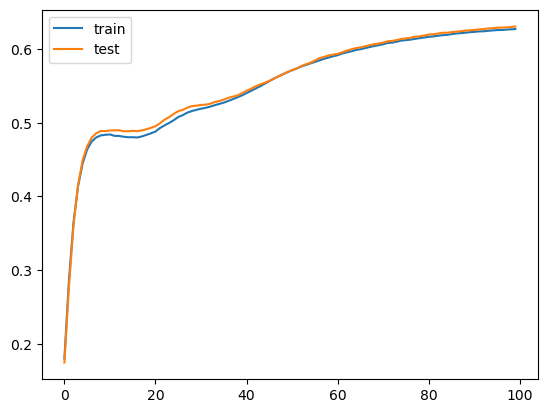

In [22]:
import numpy as np

def plot_acc(train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_accuracies, test_accuracies)